# Solving Higher-Order ODEs as First-Order Systems

A fantastic feature of our solvers (like `euler` and `rk4`) is that they already support vector-valued functions. This means we can use them to solve not just a single first-order ODE, but **systems of first-order ODEs**.

This is more powerful than it sounds! It allows us to solve higher-order ODEs by using a standard mathematical "trick": we rewrite the $n$-th order ODE as a system of $n$ first-order ODEs.

### Example: The Simple Pendulum

Consider the motion of a pendulum. If $\theta(t)$ is the angle from the vertical, its motion (with normalized constants) is described by a **second-order** ODE:

$$
\theta''(t) + \sin \theta(t) = 0
$$

Our `rk4` solver only knows how to solve equations of the form $y' = f(t,y)$. How can we use it here?

We create a **state vector** $y(t)$ that contains the angle $\theta(t)$ and its first derivative $\theta'(t)$ (the angular velocity). Let's define:

$$
y(t) = 
\begin{pmatrix}
y_1(t) \\
y_2(t)
\end{pmatrix}
=
\begin{pmatrix}
\theta(t) \\
\theta'(t)
\end{pmatrix}
$$

Now, we need to find the derivative of this vector, $y'(t)$, in terms of $y(t)$ itself. We can do this component by component:

1.  $y_1' = \theta'(t)$. By our definition, this is just $y_2(t)$.
2.  $y_2' = \theta''(t)$. From the pendulum equation, we can isolate $\theta''(t) = -\sin \theta(t)$. In terms of our state vector, this is $-\sin(y_1(t))$.

Putting this together, we get a first-order system:

$$
y'(t) =
\begin{pmatrix}
y_1'(t) \\
y_2'(t)
\end{pmatrix}
=
\begin{pmatrix}
y_2(t) \\
-\sin y_1(t)
\end{pmatrix}
=
f(t, y(t))
$$

This is now in the exact form $y' = f(t,y)$ that our solver can handle! We just need to provide an initial *vector* $y(0) = (\theta(0), \theta'(0))$.

Let's solve this for the initial condition $y(0) = (2.5, 0)$, which means releasing the pendulum from rest at an angle of 2.5 radians. We'll use $h=0.1$ up to time $T=10$.

In [1]:
# We include the rk4 function from the previous notebook
# so that this notebook can be run independently.
using Plots

function rk4(f, y0, h, N, t0=0)
    t = t0 .+ h*(0:N)
    y = zeros(length(y0), N+1)
    
    y[:,1] .= y0
    for n = 1:N
        k1 = h * f(t[n], y[:,n])
        k2 = h * f(t[n] + h/2, y[:,n] + k1/2)
        k3 = h * f(t[n] + h/2, y[:,n] + k2/2)
        k4 = h * f(t[n] + h, y[:,n] + k3)
        y[:,n+1] = y[:,n] + (k1 + 2k2 + 2k3 + k4) / 6
    end
    
    return t,y
end

rk4 (generic function with 2 methods)

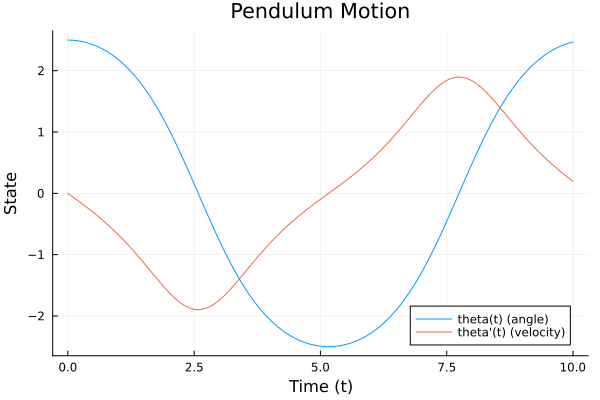

In [2]:
# Define the right-hand side function f(t,y) for the pendulum
# y is a vector: y[1] is theta, y[2] is theta'
# The output vector must be [y1', y2'] = [theta', theta'']
f(t,y) = [y[2], -sin(y[1])]

# Set up the problem
y0 = [2.5, 0]  # Initial state: theta(0)=2.5, theta'(0)=0 (released from rest)
h = 0.1         # Step size
T = 10          # Final time
N_steps = round(Int, T/h) # Total number of steps

# Solve the ODE system
t,y = rk4(f, y0, h, N_steps)

# Plot the results
# y is a 2x(N+1) array. The first row (y[1,:]) is theta(t)
# The second row (y[2,:]) is theta'(t)
# We can plot both at once by plotting the transpose y'
plot(t, y', label=["theta(t) (angle)" "theta'(t) (velocity)"],
     title="Pendulum Motion", xlabel="Time (t)", ylabel="State")

### Animating the Solution

Since we have the solution $\theta(t)$ at every time step, we can easily create an animation of the pendulum's motion.

[ Info: Saved animation to /home/persson/Programming_for_Mathematical_Applications/textbook/content/Differential_Equations/pendulum_animation.gif


Plots.AnimatedGif("/home/persson/Programming_for_Mathematical_Applications/textbook/content/Differential_Equations/pendulum_animation.gif")
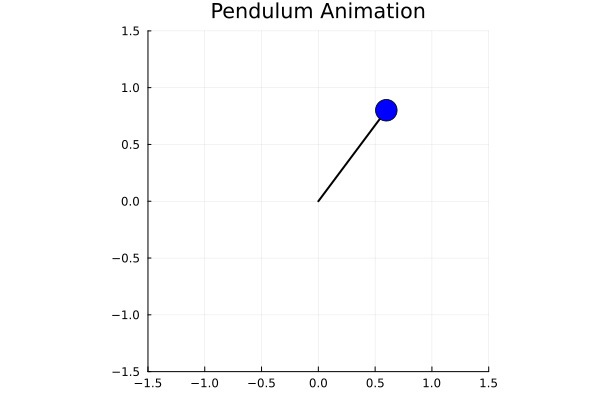

In [3]:
# Create an animation object
anim = Animation()

# Loop through every computed time step
# size(y, 2) is the number of columns (i.e., time steps)
for i = 1:size(y,2)
    # Get the angle theta at the i-th time step
    θ = y[1,i]
    
    # Calculate the (x, y) position of the pendulum bob (assuming length L=1)
    # x = L*sin(theta), y = -L*cos(theta)
    x_pos = sin(θ)
    y_pos = -cos(θ)
    
    # Create a new plot for this frame
    # We fix the axes with xlims/ylims to prevent the view from jumping around
    plot(aspect_ratio=:equal, legend=false, 
         xlims=[-1.5,1.5], ylims=[-1.5,1.5], title="Pendulum Animation")
    
    # Plot the pendulum arm (a line from the pivot (0,0) to the bob)
    plot!([0,x_pos], [0,y_pos], linewidth=2, color=:black)
    
    # Plot the pendulum bob (a scatter plot with one point)
    scatter!([x_pos], [y_pos], markersize=12, color=:blue)
    
    # Save this plot as a frame in the animation
    frame(anim)
end

# Compile all the frames into a GIF, specifying frames per second (fps)
gif(anim, "pendulum_animation.gif", fps=15)